[codecarbon WARNING @ 18:09:24] Multiple instances of codecarbon are allowed to run at the same time.


Starting trash classification pipeline...
Preparing data from C:\Users\hp\Downloads\TrashType_Image_Dataset...


Copying files: 2527 files [00:06, 413.67 files/s]


Found 1766 files belonging to 6 classes.
Found 377 files belonging to 6 classes.
Found 384 files belonging to 6 classes.
Found 6 classes


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 1280)                │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,587,462 (9.87 MB)

 Trainable params: 329,478 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)


Starting initial training with frozen base model...
Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 826ms/step - accuracy: 0.2456 - loss: 6.2926 - precision: 0.2793 - recall: 0.1031
Epoch 1: val_loss improved from inf to 5.19634, saving model to C:\Users\hp\Downloads\models\best_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.2474 - loss: 6.2861 - precision: 0.2821 - recall: 0.1042 - val_accuracy: 0.6180 - val_loss: 5.1963 - val_precision: 0.8195 - val_recall: 0.2891 - learning_rate: 1.0000e-04
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.5308 - loss: 5.3102 - precision: 0.6679 - recall: 0.3391
Epoch 2: val_loss improved from 5.19634 to 4.79617, saving model to C:\Users\hp\Downloads\models\best_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 46s 799ms/step - accuracy: 0.5317 - loss: 5.3079 - precision: 0.6688 - recall: 0.3399 - val_accuracy: 0.7188 - val_loss: 4.7962 - val_precision: 0.8458 - val_recall: 0.4801 - learning_rate: 1.0000e-04
Epoch 3/10
56/56 ━━━━━━━

<Figure size 1000x800 with 0 Axes>

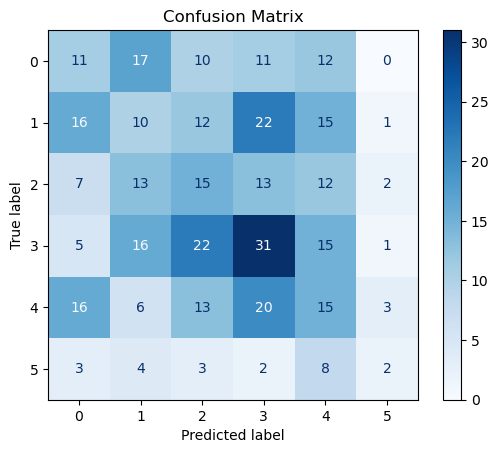


Training produced 0.00 kg of CO2
Model saved to C:\Users\hp\Downloads\models\final_model.keras

Training completed successfully!


In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import splitfolders
from codecarbon import EmissionsTracker

# Constants
SEED = 42
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
BASE_LEARNING_RATE = 1e-4
PATIENCE = 5  # For early stopping

class TrashClassifier:
    def __init__(self):  # Fixed: double underscores
        # Initialize paths - modify these according to your system
        self.base_dir = os.path.join(os.path.expanduser('~'), 'Downloads')
        self.dataset_zip = os.path.join(self.base_dir, 'archive (1).zip')
        self.dataset_dir = os.path.join(self.base_dir, 'TrashType_Image_Dataset')
        self.processed_dir = os.path.join(self.base_dir, 'processed_data')
        self.model_dir = os.path.join(self.base_dir, 'models')
        
        # Prepare environment
        self.prepare_directories()
        self.set_random_seeds()
        
    def set_random_seeds(self):
        """Set random seeds for reproducibility"""
        tf.random.set_seed(SEED)
        np.random.seed(SEED)
        os.environ['PYTHONHASHSEED'] = str(SEED)
        
    def prepare_directories(self):
        """Prepare all required directories and extract dataset if needed"""
        try:
            # Create directories if they don't exist
            os.makedirs(self.processed_dir, exist_ok=True)
            os.makedirs(self.model_dir, exist_ok=True)
            
            # Extract dataset if needed
            if os.path.exists(self.dataset_zip) and not os.path.exists(self.dataset_dir):
                print("Extracting dataset...")
                with zipfile.ZipFile(self.dataset_zip, 'r') as zip_ref:
                    zip_ref.extractall(self.base_dir)
                print(f"Dataset extracted to {self.dataset_dir}")
                
            if not os.path.exists(self.dataset_dir):
                raise FileNotFoundError(f"Dataset directory not found: {self.dataset_dir}")
                
        except Exception as e:
            print(f"Error preparing directories: {e}")
            raise

    def prepare_data(self):
        """Split data into train/val/test sets"""
        try:
            print(f"Preparing data from {self.dataset_dir}...")
            splitfolders.ratio(
                self.dataset_dir,
                output=self.processed_dir,
                seed=SEED,
                ratio=(0.7, 0.15, 0.15),  # 70% train, 15% val, 15% test
                group_prefix=None,
                move=False
            )
            return True
        except Exception as e:
            print(f"Error preparing data: {e}")
            return False

    def create_datasets(self):
        """Create optimized TensorFlow datasets with augmentation"""
        try:
            train_dir = os.path.join(self.processed_dir, 'train')
            val_dir = os.path.join(self.processed_dir, 'val')
            test_dir = os.path.join(self.processed_dir, 'test')
            
            # Data augmentation pipeline
            augmentation = keras.Sequential([
                layers.RandomFlip("horizontal_and_vertical"),
                layers.RandomRotation(0.2),
                layers.RandomZoom(0.2),
                layers.RandomContrast(0.1),
            ], name="data_augmentation")

            # Load and preprocess datasets
            train_ds = keras.utils.image_dataset_from_directory(
                train_dir,
                image_size=IMG_SIZE,
                batch_size=BATCH_SIZE,
                label_mode='categorical',
                shuffle=True,
                seed=SEED
            ).map(lambda x, y: (augmentation(x, training=True), y),
                num_parallel_calls=tf.data.AUTOTUNE)
            
            val_ds = keras.utils.image_dataset_from_directory(
                val_dir,
                image_size=IMG_SIZE,
                batch_size=BATCH_SIZE,
                label_mode='categorical'
            )
            
            test_ds = keras.utils.image_dataset_from_directory(
                test_dir,
                image_size=IMG_SIZE,
                batch_size=BATCH_SIZE,
                label_mode='categorical'
            )
            
            # Optimize dataset performance
            AUTOTUNE = tf.data.AUTOTUNE
            train_ds = train_ds.prefetch(AUTOTUNE)
            val_ds = val_ds.prefetch(AUTOTUNE)
            
            return train_ds, val_ds, test_ds
        except Exception as e:
            print(f"Error creating datasets: {e}")
            return None, None, None

    def build_model(self, num_classes):
        """Build and compile the transfer learning model"""
        # Load pre-trained base model
        base_model = keras.applications.MobileNetV2(
            input_shape=IMG_SIZE + (3,),
            include_top=False,
            weights='imagenet',
            pooling='avg'
        )
        base_model.trainable = False  # Freeze base model initially

        # Build custom model architecture
        inputs = keras.Input(shape=IMG_SIZE + (3,))
        x = keras.applications.mobilenet_v2.preprocess_input(inputs)
        x = base_model(x, training=False)
        x = layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(num_classes, activation='softmax')(x)
        
        model = keras.Model(inputs, outputs)
        
        # Compile with custom learning rate
        optimizer = keras.optimizers.Adam(learning_rate=BASE_LEARNING_RATE)
        model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=[
                'accuracy',
                keras.metrics.Precision(name='precision'),
                keras.metrics.Recall(name='recall')
            ]
        )
        
        return model, base_model

    def train(self):
        """Main training workflow with emissions tracking"""
        tracker = EmissionsTracker(log_level='error')
        model = None
        
        try:
            tracker.start()
            
            # Data preparation
            if not self.prepare_data():
                raise RuntimeError("Data preparation failed")
                
            # Dataset creation
            train_ds, val_ds, test_ds = self.create_datasets()
            if train_ds is None:
                raise RuntimeError("Dataset creation failed")
                
            # Model setup
            num_classes = len(os.listdir(os.path.join(self.processed_dir, 'train')))
            print(f"Found {num_classes} classes")
            
            model, base_model = self.build_model(num_classes)
            model.summary()
            
            # Callbacks
            callbacks = [
                ModelCheckpoint(
                    os.path.join(self.model_dir, 'best_model.keras'),  # Using new .keras format
                    monitor='val_loss',
                    save_best_only=True,
                    save_weights_only=False,
                    mode='min',
                    verbose=1
                ),
                EarlyStopping(
                    monitor='val_loss',
                    patience=PATIENCE,
                    restore_best_weights=True,
                    verbose=1
                ),
                ReduceLROnPlateau(
                    monitor='val_loss',
                    factor=0.2,
                    patience=PATIENCE//2,
                    min_lr=1e-6,
                    verbose=1
                )
            ]
            
            # Training phase 1: Frozen base model
            print("\nStarting initial training with frozen base model...")
            history = model.fit(
                train_ds,
                validation_data=val_ds,
                epochs=EPOCHS,
                callbacks=callbacks,
                verbose=1
            )
            
            # Training phase 2: Fine-tuning
            print("\nStarting fine-tuning...")
            base_model.trainable = True
            model.compile(
                optimizer=keras.optimizers.Adam(learning_rate=BASE_LEARNING_RATE/10),
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )
            
            history_fine = model.fit(
                train_ds,
                validation_data=val_ds,
                epochs=EPOCHS//2,  # Fewer epochs for fine-tuning
                initial_epoch=history.epoch[-1] + 1,
                callbacks=callbacks,
                verbose=1
            )
            
            # Evaluation
            print("\nEvaluating final model...")
            self.evaluate_model(model, test_ds)
            
            return model
            
        except Exception as e:
            print(f"Error during training: {e}")
            return None
            
        finally:
            emissions = tracker.stop()
            print(f"\nTraining produced {emissions:.2f} kg of CO2")
            
            if model is not None:
                model_path = os.path.join(self.model_dir, 'final_model.keras')  # Using new .keras format
                model.save(model_path, save_format='keras')
                print(f"Model saved to {model_path}")
            else:
                print("No model to save due to previous errors")

    def evaluate_model(self, model, test_ds):
        """Comprehensive model evaluation"""
        # Get predictions and true labels
        y_pred = model.predict(test_ds)
        y_true = np.concatenate([y for x, y in test_ds], axis=0)
        y_true = np.argmax(y_true, axis=1)
        y_pred = np.argmax(y_pred, axis=1)
        
        # Classification report
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, digits=4))
        
        # Confusion matrix
        plt.figure(figsize=(10, 8))
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues', values_format='d')
        plt.title('Confusion Matrix')
        plt.show()

if __name__ == "__main__":  # Fixed: double underscores
    # Configure environment
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Reduce TensorFlow logging
    physical_devices = tf.config.list_physical_devices('GPU')
    if physical_devices:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    
    print("Starting trash classification pipeline...")
    classifier = TrashClassifier()
    trained_model = classifier.train()
    
    if trained_model is not None:
        print("\nTraining completed successfully!")
    else:
        print("\nTraining encountered errors")